# Chainer basic module introduction 2

Advanced memo is written as "Note". You can skip reading this for the first time reading.

In previous tutorial, we learned
* Variable
* Link
* Function
* Chain

Let's try training the model (Chain) in this tutorial.
In this section, we will learn

* Optimizer   - Optimizes/tunes the internal parameter to fit to the target function
* Serializer  - Handle save/load the model (Chain)

For other chainer modules are explained in later tutorial.

## Training

What we want to do here is regression analysis (Wikipedia).
Given set of input `x` and its output `y`, 
we would like to construct a model (function) which estimates `y` as close as possible from given input `x`.

This is done by tuning an internal parameters of model (this is represented by Chain class in Chainer).
And the procedure to tune this internal parameters of model to get a desired model is often denoted as "training".

## Initial setup

Below is typecal `import` statement of chainer modules.

In [28]:
# Initial setup following http://docs.chainer.org/en/stable/tutorial/basic.html
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

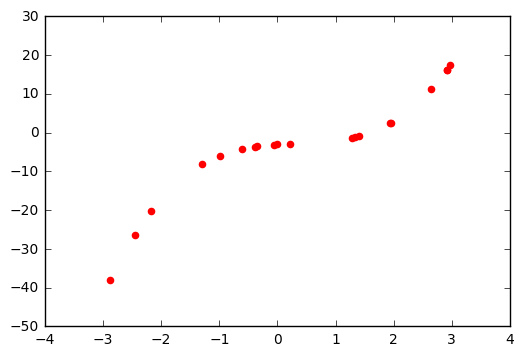

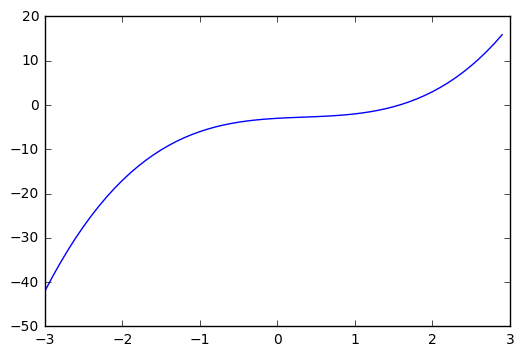

In [111]:
import matplotlib.pyplot as plt


# define target function
def target_func(x):
    """Target function to be predicted"""
    return x ** 3 - x ** 2 + x - 3

# create efficient function to calculate target_func of numpy array in element wise
target_func_elementwise = np.frompyfunc(target_func, 1, 1)


# define data domain [xmin, xmax]
xmin = -3
xmax = 3
# number of training data
sample_num = 20
x_data = np.array(np.random.rand(sample_num) * (xmax - xmin) + xmin)  # create 20 
y_data = target_func_elementwise(x_data)

x_detail_data = np.array(np.arange(xmin, xmax, 0.1))
y_detail_data = target_func_elementwise(x_detail_data)


# plot training data
plt.clf()
plt.scatter(x_data, y_data, color='r')
plt.show()
#print('x', x_data, 'y', y_data)

# plot target function
plt.clf()
plt.plot(x_detail_data, y_detail_data)
plt.show()

Our task is to make regression 

## Linear regression using sklearn

You can skip this section if you are only interested in Chainer or deep learning.
At first, let's see linear regression approach. 
using sklearn library, 

Reference: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

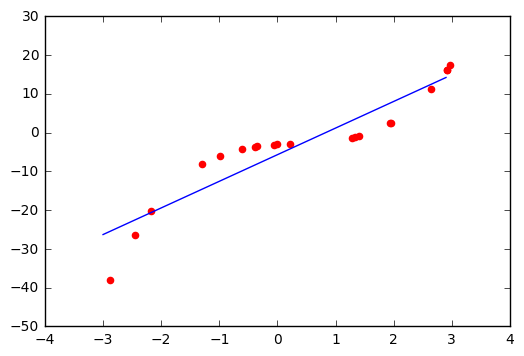

In [112]:
from sklearn import linear_model

# clf stands for 'classifier'
model = linear_model.LinearRegression()
model.fit(x_data.reshape(-1, 1), y_data)

y_predict_data = model.predict(x_detail_data.reshape(-1, 1))
plt.clf()
plt.scatter(x_data, y_data, color='r')
plt.plot(x_detail_data, y_predict_data)
plt.show()

## Optimizer
Chainer optimizer manages the optimization process of model fit.

Concretely, current deep learning works based on the technic of Stocastic Gradient Descent (SGD) based method.
Chainer provides several optimizers in `chainer.optimizers` module, which includes following

* SGD
* MomentumSGD
* AdaGrad
* AdaDelta
* Adam

Around my community, MomentumSGD and Adam are more used these days.

Here we define the 

## Construct model - implement your own Chain

`Chain` is to construct neural networks.

Let's see example,

In [113]:
from chainer import Chain, Variable


# Defining your own neural networks using `Chain` class
class MyChain(Chain):
    def __init__(self):
        super(MyChain, self).__init__(
            l1=L.Linear(None, 30),
            l2=L.Linear(None, 30),
            l3=L.Linear(None, 1)
        )
        
    def __call__(self, x):
        h = self.l1(x)
        h = self.l2(F.sigmoid(h))
        return self.l3(F.sigmoid(h))

Here we define the 

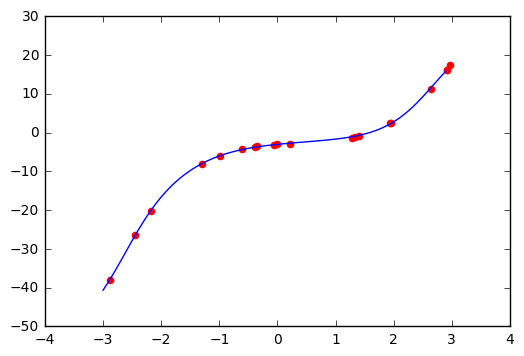

In [117]:
# Setup a model
model = MyChain()
# Setup an optimizer
optimizer = chainer.optimizers.MomentumSGD()
optimizer.use_cleargrads()  # this is for performance efficiency
optimizer.setup(model)

x = Variable(x_data.reshape(-1, 1).astype(np.float32))
y = Variable(y_data.reshape(-1, 1).astype(np.float32))


def lossfun(x, y):
    loss = F.mean_squared_error(model(x), y)
    return loss

# this iteration is "training", to fit the model into desired function.
for i in range(300):
    optimizer.update(lossfun, x, y)

    # above one code can be replaced by below 4 codes.
    # model.cleargrads()
    # loss = lossfun(x, y)
    # loss.backward()
    # optimizer.update()


y_predict_data = model(x_detail_data.reshape(-1, 1).astype(np.float32)).data

plt.clf()
plt.scatter(x_data, y_data, color='r')
plt.plot(x_detail_data, np.squeeze(y_predict_data, axis=1))
plt.show()

Based on the [official doc](http://docs.chainer.org/en/stable/tutorial/basic.html#write-a-model-as-a-chain), `Chain` class provides following functionality
* parameter management
* CPU/GPU migration support
* save/load features

to provide convinient reusability of your neural network code.